In [3]:
print("Hello world")

Hello world


In [4]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tqdm import tqdm  # Import tqdm
import matplotlib.pyplot as plt
import datetime
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [6]:
class SemArtDataset(Dataset):
    def __init__(self, dataframe, base_path, transform=None):
        self.dataframe = dataframe
        self.base_path = base_path
        self.transform = transform
        self.image_files = dataframe['IMAGE_FILE'].values
        self.labels = dataframe['TYPE'].values
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.base_path, img_name)
        image = Image.open(img_path)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [7]:
# Define transforms: Resize, Normalize and Convert to Tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    
])


In [9]:
def filter_by_start_year(df, start_year=1401):
    """
    Filters a dataframe to include rows where the "TIMEFRAME" column 
    starts from a given year or later.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        start_year (int): The minimum start year for filtering (default is 1401).

    Returns:
        pd.DataFrame: A filtered dataframe.
    """
    # Extract the start year from the TIMEFRAME column
    df["START_YEAR"] = df["TIMEFRAME"].str.split('-').str[0].astype(int)

    # Filter the dataframe based on the start year
    filtered_df = df[df["START_YEAR"] >= start_year]

    # Drop the START_YEAR column (optional)
    filtered_df = filtered_df.drop(columns=["START_YEAR"])

    return filtered_df

In [10]:
# Load CSV files
train_df = pd.read_csv("data/semart_train.csv", sep="\t", encoding="ISO-8859-1")
test_df = pd.read_csv("data/semart_test.csv", sep="\t", encoding="ISO-8859-1")
val_df = pd.read_csv("data/semart_val.csv", sep="\t", encoding="ISO-8859-1")

train_df = filter_by_start_year(train_df, start_year=1401)
val_df = filter_by_start_year(val_df, start_year=1401)
test_df = filter_by_start_year(test_df, start_year=1401)

# Hard-code the classes to focus on: 'religious', 'portrait', 'landscape'
target_classes = ['religious', 'portrait', 'landscape',"still-life","mythological"]

# Filter the DataFrames to include only these three classes
train_df = train_df[train_df['TYPE'].isin(target_classes)]
val_df = val_df[val_df['TYPE'].isin(target_classes)]
test_df = test_df[test_df['TYPE'].isin(target_classes)]

original_class_labels = train_df['TYPE'].unique()

# Reduce dataset size
train_df = train_df.head(2)
test_df = train_df
val_df = train_df

# Label encoding
le = LabelEncoder()
train_df['TYPE'] = le.fit_transform(train_df['TYPE'])
test_df['TYPE'] = le.transform(test_df['TYPE'])
val_df['TYPE'] = le.transform(val_df['TYPE'])

encoded_to_original = dict(zip(range(len(le.classes_)), le.classes_))

# Load dataset
base_path = 'processed_imagesV2/'
train_dataset = SemArtDataset(train_df, base_path, transform=transform)
val_dataset = SemArtDataset(val_df, base_path, transform=transform)
test_dataset = SemArtDataset(test_df, base_path, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True) #Was True 

# Freeze the layers of VGG16 (optional for fine-tuning)
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer (classifier) with a new one for our dataset
num_classes = len(np.unique(train_df['TYPE']))  # Number of classes in the dataset
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Move model to device (GPU or CPU)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001) 

#When you have network train your model with 2 images. Loss needs to go 0.0. We expect our model to ourfit. 
#overfit test

#It is too slow, it will crep to go 0.0. 

#overfit on at least 1 samlple, but our goal isn't to overfit.

#Should always try out





#Default 0.001
#zelfde idee als SGD; lr is learning rate


#drop outs uitproberen

In [50]:
# Load the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Freeze the convolutional base (optional, if fine-tuning specific layers)
for param in model.features.parameters():
    param.requires_grad = False

num_classes = len(np.unique(train_df['TYPE']))  # Number of classes in the dataset


amountofnodes = []
# Define the new classifier
new_classifier = nn.Sequential(
    nn.Linear(25088, 4096),  # First fully connected layer
    nn.ReLU(inplace=True),  # Activation function
    nn.Dropout(p=0.5),      # Dropout layer
    nn.Linear(4096, 4096),  # Second fully connected layer
    nn.ReLU(inplace=True),  # Activation function
    nn.Dropout(p=0.5),      # Dropout layer
    nn.Linear(4096, num_classes)   # Output layer (for 1000 classes, modify if needed)
)


# Replace the original classifier
model.classifier = new_classifier

# Move model to device (GPU or CPU)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001) 

# Check the model architecture
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch 1/10 - Training: 100%|██████████| 10/10 [00:03<00:00,  3.19batch/s, accuracy=0.382, loss=4.67]


Epoch [1/10], Training Loss: 4.6674, Training Accuracy: 0.3818


Epoch 1/10 - Validation: 100%|██████████| 1/1 [00:00<00:00,  7.25batch/s, accuracy=0.625, loss=1.18]


new best model
Epoch [1/10], Validation Loss: 1.1770, Validation Accuracy: 0.6250


Epoch 2/10 - Training: 100%|██████████| 10/10 [00:03<00:00,  2.97batch/s, accuracy=0.699, loss=0.756]


Epoch [2/10], Training Loss: 0.7559, Training Accuracy: 0.6993


Epoch 2/10 - Validation: 100%|██████████| 1/1 [00:00<00:00,  6.64batch/s, accuracy=0.812, loss=0.963]


new best model
Epoch [2/10], Validation Loss: 0.9629, Validation Accuracy: 0.8125


Epoch 3/10 - Training: 100%|██████████| 10/10 [00:03<00:00,  2.96batch/s, accuracy=0.858, loss=0.364]


Epoch [3/10], Training Loss: 0.3638, Training Accuracy: 0.8581


Epoch 3/10 - Validation: 100%|██████████| 1/1 [00:00<00:00,  7.09batch/s, accuracy=0.438, loss=1.61]


Epoch [3/10], Validation Loss: 1.6089, Validation Accuracy: 0.4375


Epoch 4/10 - Training: 100%|██████████| 10/10 [00:03<00:00,  3.17batch/s, accuracy=0.956, loss=0.125]


Epoch [4/10], Training Loss: 0.1254, Training Accuracy: 0.9561


Epoch 4/10 - Validation: 100%|██████████| 1/1 [00:00<00:00,  7.63batch/s, accuracy=0.5, loss=1.66]


Epoch [4/10], Validation Loss: 1.6577, Validation Accuracy: 0.5000


Epoch 5/10 - Training: 100%|██████████| 10/10 [00:02<00:00,  3.42batch/s, accuracy=0.993, loss=0.0337]


Epoch [5/10], Training Loss: 0.0337, Training Accuracy: 0.9932


Epoch 5/10 - Validation: 100%|██████████| 1/1 [00:00<00:00,  7.09batch/s, accuracy=0.625, loss=1.48]


Epoch [5/10], Validation Loss: 1.4831, Validation Accuracy: 0.6250


Epoch 6/10 - Training: 100%|██████████| 10/10 [00:03<00:00,  3.33batch/s, accuracy=0.986, loss=0.0637]


Epoch [6/10], Training Loss: 0.0637, Training Accuracy: 0.9865


Epoch 6/10 - Validation: 100%|██████████| 1/1 [00:00<00:00,  7.14batch/s, accuracy=0.375, loss=2.94]


Epoch [6/10], Validation Loss: 2.9401, Validation Accuracy: 0.3750


Epoch 7/10 - Training: 100%|██████████| 10/10 [00:02<00:00,  3.39batch/s, accuracy=0.997, loss=0.0117]


Epoch [7/10], Training Loss: 0.0117, Training Accuracy: 0.9966


Epoch 7/10 - Validation: 100%|██████████| 1/1 [00:00<00:00,  6.99batch/s, accuracy=0.562, loss=2.27]


Epoch [7/10], Validation Loss: 2.2711, Validation Accuracy: 0.5625


Epoch 8/10 - Training: 100%|██████████| 10/10 [00:02<00:00,  3.41batch/s, accuracy=0.993, loss=0.0165]


Epoch [8/10], Training Loss: 0.0165, Training Accuracy: 0.9932


Epoch 8/10 - Validation: 100%|██████████| 1/1 [00:00<00:00,  7.03batch/s, accuracy=0.5, loss=2.73]


Epoch [8/10], Validation Loss: 2.7342, Validation Accuracy: 0.5000


Epoch 9/10 - Training: 100%|██████████| 10/10 [00:03<00:00,  3.23batch/s, accuracy=0.99, loss=0.0307]


Epoch [9/10], Training Loss: 0.0307, Training Accuracy: 0.9899


Epoch 9/10 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.43batch/s, accuracy=0.375, loss=4.2]


Epoch [9/10], Validation Loss: 4.1966, Validation Accuracy: 0.3750


Epoch 10/10 - Training: 100%|██████████| 10/10 [00:03<00:00,  3.23batch/s, accuracy=1, loss=0.00345]


Epoch [10/10], Training Loss: 0.0035, Training Accuracy: 1.0000


Epoch 10/10 - Validation: 100%|██████████| 1/1 [00:00<00:00,  6.99batch/s, accuracy=0.5, loss=2.66]


Epoch [10/10], Validation Loss: 2.6597, Validation Accuracy: 0.5000


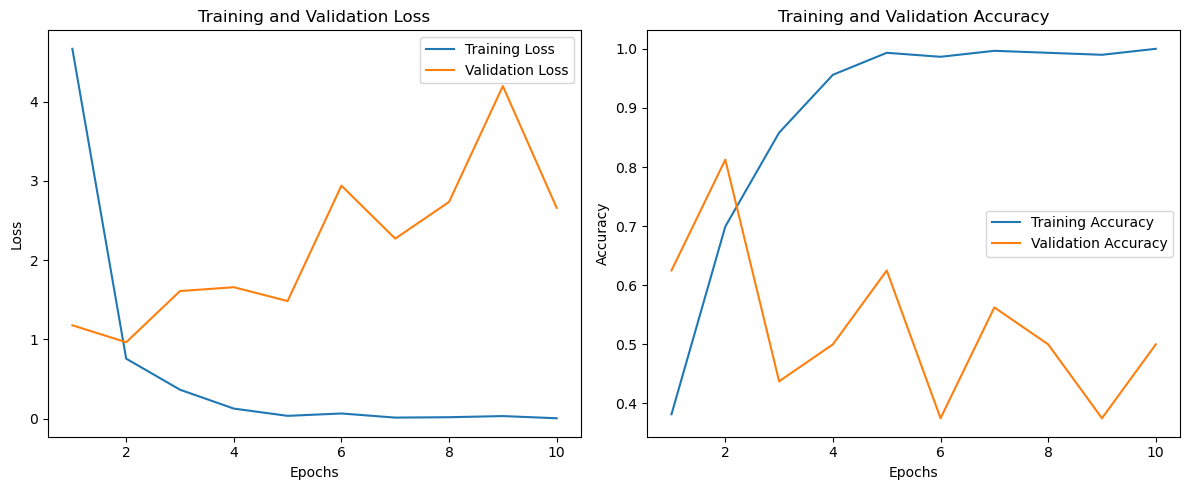

In [51]:
naam = f"{datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")}_BestModel"

# Training Loop with Tracking
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_validation_loss = np.inf

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    # Wrap the train_loader with tqdm for progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch") as progress_bar:
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device).long()  # Cast labels to torch.long

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
            
            # Update the progress bar description
            progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1), accuracy=correct_preds / total_preds)
    
    # Calculate training loss and accuracy
    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_accuracy = correct_preds / total_preds
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.4f}")
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct_preds = 0
    val_total_preds = 0

    with torch.no_grad():
        with tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch") as val_bar:
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device).long()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Track loss and accuracy
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct_preds += (predicted == labels).sum().item()
                val_total_preds += labels.size(0)

                # Update validation progress bar
                val_bar.set_postfix(loss=val_running_loss / (val_bar.n + 1), accuracy=val_correct_preds / val_total_preds)

    # Calculate validation loss and accuracy
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_accuracy = val_correct_preds / val_total_preds
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)


    #hoogste opslaan Doe accuracy
    if val_epoch_loss<best_validation_loss:
        print("new best model")
        best_validation_loss = val_epoch_loss
        torch.save(model, f'trainedmodels\\{naam}.pth')



    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()

plt.savefig(f"trainedmodels\\{naam}.png", dpi=300)

plt.show()


#with augmentation: training loss will go down slower. "Learn slower learn better"

In [ ]:
# Evaluate the model on the validation and test set
model = torch.load('trainedmodels\\2025_01_09_12_17_BestModel.pth')  # Load your trained model
model.to(device)  # Ensure the model is on the correct device

model.eval()
correct_preds = 0
total_preds = 0

# Evaluate on validation set
for inputs, labels in val_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

val_accuracy = correct_preds / total_preds
print(f"Validation accuracy: {val_accuracy:.4f}")

# Evaluate on test set
correct_preds = 0
total_preds = 0

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

test_accuracy = correct_preds / total_preds
print(f"Test accuracy: {test_accuracy:.4f}")


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17400\1817500465.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('2025_01_09_12_17_BestModel.pth')  # 

Validation accuracy: 0.8438
Test accuracy: 0.8182
